# 23 - ANOVA analysis

ANOVA - Analysis of variance

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
from scipy.stats import f_oneway
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

## Config notebook

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = False
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 9
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## __Load data__

### __Load data__ - Pois proximity (regular and unique ID pois)

In [5]:
if local_data:
    hex_gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_{speed_name}_kmh_res{res}.gpkg')
else:
    query = f'SELECT * FROM projects_research.santiago_hexanalysis_{speed_name}_kmh WHERE res = {res}'
    hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(9080, 31)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res
0,0.0,0.0,2.0,0.116099,0.0,0.0,2.116099,0.401235,0.0,3.333333,...,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",0.133745,0.903161,2.222222,0.358975,0.0,0.003983,3.622086,9


### __Load data__ - Comunas

In [6]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')
elif all_local_dirs == 'edgar':
    comuna_gdf = gpd.read_file(grl_dir + 'santiago_comunas.geojson')

# Show
comuna_gdf = comuna_gdf.explode()
comuna_gdf['area_ha'] = comuna_gdf.to_crs("EPSG:32719").area/10000
comuna_gdf = comuna_gdf[['Comuna','area_ha','geometry']]
comuna_gdf = comuna_gdf.rename(columns={'Comuna':'Nombre'})
comuna_gdf = comuna_gdf.reset_index(drop=True)
print(comuna_gdf.shape)
comuna_gdf.head(1)

(36, 3)


,Nombre,area_ha,geometry
0,San Joaquín,987.687671,"POLYGON ((-70.62342 -33.47338, -70.62292 -33.4..."


### __Load data__ - Buffer Alameda

In [7]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')
elif all_local_dirs == 'edgar':
    alameda_gdf = gpd.read_file(grl_dir + 'unidades_vecinales_buffer800m_alameda_v2.gpkg')

# Show
alameda_gdf = alameda_gdf.dissolve()
alameda_gdf['area_ha'] = alameda_gdf.to_crs("EPSG:32719").area/10000
alameda_gdf['Nombre'] = 'Nueva Alameda'
alameda_gdf = alameda_gdf[['Nombre','area_ha','geometry']]
print(alameda_gdf.shape)
alameda_gdf.head(1)

(1, 3)


,Nombre,area_ha,geometry
0,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."


## ANOVA

### Data by area of analysis

In [8]:
nombre_comuna = ['Las Condes','Pedro Aguirre Cerda',
                'Quinta Normal','San Miguel',
                'Maipú','Conchalí','El Bosque',
                'Providencia']
comuna_analysis = comuna_gdf.loc[comuna_gdf.Nombre.isin(nombre_comuna)].copy()
comparison_gdf = pd.concat([comuna_analysis,alameda_gdf])
comparison_gdf

,Nombre,area_ha,geometry
1,San Miguel,963.502832,"POLYGON ((-70.63659 -33.51873, -70.63740 -33.5..."
6,Providencia,1439.652277,"POLYGON ((-70.58484 -33.43126, -70.58445 -33.4..."
17,Conchalí,1098.672380,"POLYGON ((-70.66314 -33.39923, -70.66400 -33.3..."
18,El Bosque,1426.967489,"POLYGON ((-70.66324 -33.58516, -70.66340 -33.5..."
23,Las Condes,9839.607402,"POLYGON ((-70.53235 -33.38217, -70.53235 -33.3..."
28,Maipú,13803.803111,"POLYGON ((-70.76505 -33.45926, -70.76505 -33.4..."
30,Pedro Aguirre Cerda,850.130544,"POLYGON ((-70.67123 -33.51069, -70.67179 -33.5..."
33,Quinta Normal,1186.605299,"POLYGON ((-70.70527 -33.40762, -70.70463 -33.4..."
0,Nueva Alameda,2266.840098,"POLYGON ((-70.71634 -33.46959, -70.71651 -33.4..."


### Spatial intersection

In [9]:
hex_analysis = hex_gdf.merge(hex_gdf.sjoin(comparison_gdf)[['hex_id','Nombre']], on='hex_id',
                             how='right')
print(hex_analysis.shape)
hex_analysis.head(4)

(2507, 32)


,wellbeing_supplying,wellbeing_caring,wellbeing_living,wellbeing_enjoying,wellbeing_learning,wellbeing_working,wellbeing,sociability_supplying,sociability_caring,sociability_living,...,geometry,supplying,caring,living,enjoying,learning,working,hqsl,res,Nombre
0,4.099206,4.616402,0.000000,2.732195,2.702381,3.750000,17.900185,7.023810,2.986111,3.333333,...,"POLYGON ((-70.60396 -33.44091, -70.60513 -33.4...",5.725309,4.862116,1.800265,3.246885,1.770282,5.113402,22.518257,9,Providencia
1,2.500000,0.937500,0.800000,0.832534,2.883333,3.333333,11.286701,2.694444,3.000000,2.031009,...,"POLYGON ((-70.70833 -33.42848, -70.70950 -33.4...",2.842593,2.093014,1.472241,1.239184,3.379630,2.709531,13.736193,9,Quinta Normal
2,1.632353,0.574449,0.411765,0.651915,1.022059,3.333333,7.625873,1.997549,4.485294,3.333333,...,"POLYGON ((-70.78412 -33.53905, -70.78529 -33.5...",1.850490,1.922509,2.450980,2.838212,0.955882,1.678922,11.696996,9,Maipú
3,2.731481,2.181713,0.152778,1.654908,2.486111,3.495370,12.702361,3.495370,3.958333,4.507845,...,"POLYGON ((-70.64368 -33.49980, -70.64485 -33.5...",3.335905,3.049427,1.943973,1.828611,1.959877,3.598161,15.715954,9,San Miguel


### Distribution analysis

In [27]:
variable_analysis = 'environmental_impact_living'

Count data

In [28]:
hex_analysis[['Nombre',variable_analysis]].groupby('Nombre').count()

,environmental_impact_living
Nombre,
Conchalí,149
El Bosque,187
Las Condes,569
Maipú,680
Nueva Alameda,313
Pedro Aguirre Cerda,118
Providencia,190
Quinta Normal,167
San Miguel,134


In [29]:
hex_anova = hex_analysis.groupby('Nombre').apply(lambda x: x.sample(n=100), include_groups=False).reset_index().drop(columns='level_1')
hex_anova[['Nombre',variable_analysis]].groupby('Nombre').count()

,environmental_impact_living
Nombre,
Conchalí,100
El Bosque,100
Las Condes,100
Maipú,100
Nueva Alameda,100
Pedro Aguirre Cerda,100
Providencia,100
Quinta Normal,100
San Miguel,100


Box plot

<AxesSubplot: xlabel='Nombre', ylabel='environmental_impact_living'>

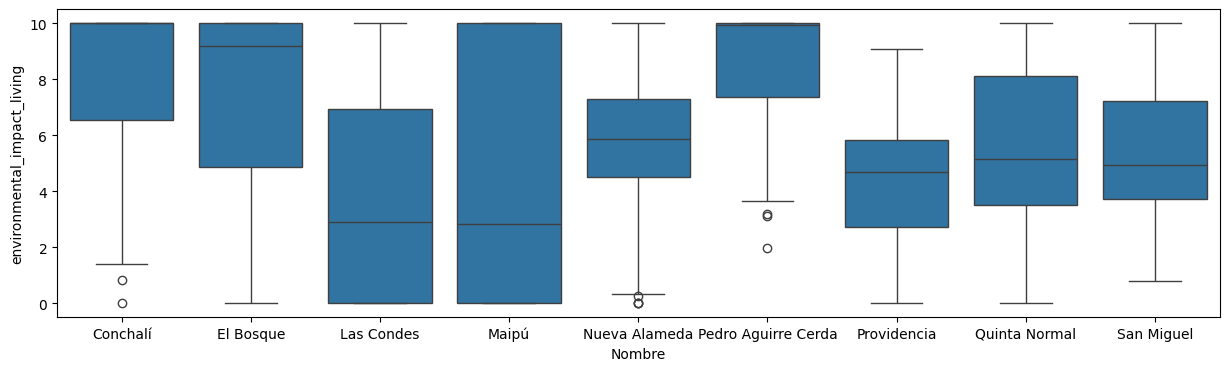

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.boxplot(x='Nombre', y=variable_analysis, data=hex_anova, ax=ax)
# sns.swarmplot(x="Nombre", y=variable_analysis, data=hex_analysis, color='black', alpha = 0.5, ax=ax);

QQ Plot

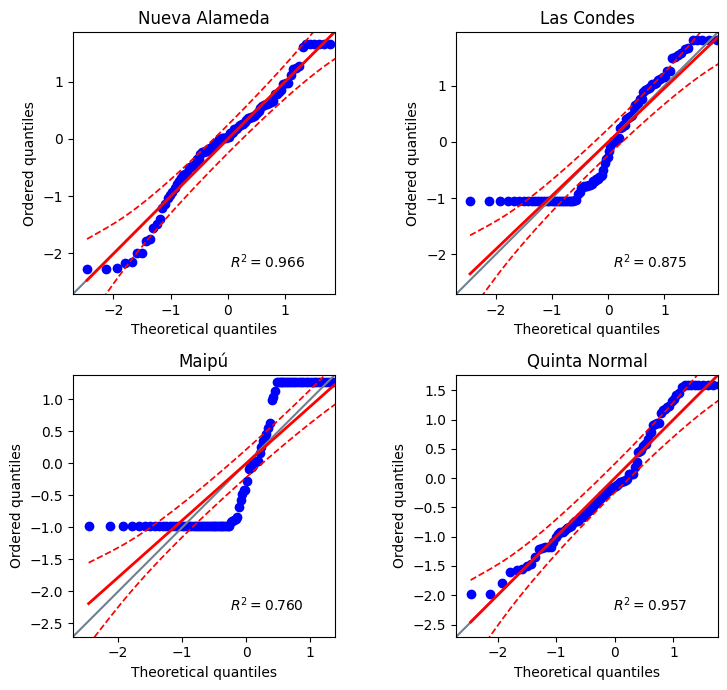

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
pg.qqplot(hex_anova.loc[hex_anova.Nombre=='Nueva Alameda', variable_analysis], dist='norm', ax=axs[0,0])
axs[0,0].set_title('Nueva Alameda')
pg.qqplot(hex_anova.loc[hex_anova.Nombre=='Las Condes', variable_analysis], dist='norm', ax=axs[0,1])
axs[0,1].set_title('Las Condes')
pg.qqplot(hex_anova.loc[hex_anova.Nombre=='Maipú', variable_analysis], dist='norm', ax=axs[1,0])
axs[1,0].set_title('Maipú')
pg.qqplot(hex_anova.loc[hex_anova.Nombre=='Quinta Normal', variable_analysis], dist='norm', ax=axs[1,1])
axs[1,1].set_title('Quinta Normal')
plt.tight_layout()

In [35]:
pg.normality(data=hex_anova, dv=variable_analysis, group='Nombre')

,W,pval,normal
Nombre,,,
Conchalí,0.719459,1.569898e-12,False
El Bosque,0.755090,1.278989e-11,False
Las Condes,0.864127,4.092504e-08,False
Maipú,0.748318,8.453226e-12,False
Nueva Alameda,0.959484,3.695394e-03,False
Pedro Aguirre Cerda,0.753122,1.133049e-11,False
Providencia,0.919810,1.375261e-05,False
Quinta Normal,0.948729,6.848200e-04,False
San Miguel,0.947462,5.666967e-04,False


In [36]:
# Test de homocedasticidad
# ==============================================================================
pg.homoscedasticity(data=hex_anova, dv=variable_analysis, group='Nombre', method='levene')

,W,pval,equal_var
levene,15.036899,8.308363e-21,False


In [87]:
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns',20)


array(<generator object <genexpr> at 0x7ed4b916ccf0>, dtype=object)

In [37]:
pg.anova(data=hex_anova, dv=variable_analysis, between='Nombre', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Nombre,2377.121365,8,297.140171,31.588746,8.095683e-44,0.220956
1,Within,8381.209241,891,9.406520,NaN,NaN,NaN


In [43]:
hex_var_anova = pg.pairwise_tukey(data=hex_anova, dv=variable_analysis, between='Nombre').round(3)
hex_var_anova[(hex_var_anova.A=='Nueva Alameda')|(hex_var_anova.B=='Nueva Alameda')]

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
3,Conchalí,Nueva Alameda,8.127,5.770,2.356,0.434,5.433,0.000,0.883
10,El Bosque,Nueva Alameda,7.044,5.770,1.273,0.434,2.935,0.082,0.396
16,Las Condes,Nueva Alameda,3.671,5.770,-2.100,0.434,-4.841,0.000,-0.681
21,Maipú,Nueva Alameda,4.360,5.770,-1.411,0.434,-3.252,0.032,-0.386
26,Nueva Alameda,Pedro Aguirre Cerda,5.770,8.501,-2.730,0.434,-6.294,0.000,-1.167
27,Nueva Alameda,Providencia,5.770,4.130,1.641,0.434,3.783,0.005,0.657
28,Nueva Alameda,Quinta Normal,5.770,5.555,0.216,0.434,0.498,1.000,0.080
29,Nueva Alameda,San Miguel,5.770,5.512,0.258,0.434,0.596,1.000,0.103


In [38]:
# Post-hoc Tukey test
# ==============================================================================
df_summary_result = pd.DataFrame()
col_analysis = ['sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']
for i in range(len(col_analysis)):
    
    df_result = pg.pairwise_tukey(data=hex_anova, dv=col_analysis[i], between='Nombre').round(3)
    df_result = df_result.loc[(df_result.A=='Nueva Alameda')|(df_result.B=='Nueva Alameda')]
    df_result = df_result[['A','B','mean(A)','mean(B)','diff','p-tukey']].add_prefix(f'{col_analysis[i]}_')
    df_result = df_result.rename(columns={f'{col_analysis[i]}_A':'A',
                                         f'{col_analysis[i]}_B':'B'})
    if i == 0:
        df_summary_result = df_result
    else:
        df_summary_result = df_summary_result.merge(df_result, on=['A','B'])

In [39]:
pd.set_option('display.max_columns',None)
df_summary_result

,A,B,sociability_mean(A),sociability_mean(B),sociability_diff,sociability_p-tukey,wellbeing_mean(A),wellbeing_mean(B),wellbeing_diff,wellbeing_p-tukey,environmental_impact_mean(A),environmental_impact_mean(B),environmental_impact_diff,environmental_impact_p-tukey,supplying_mean(A),supplying_mean(B),supplying_diff,supplying_p-tukey,caring_mean(A),caring_mean(B),caring_diff,caring_p-tukey,living_mean(A),living_mean(B),living_diff,living_p-tukey,enjoying_mean(A),enjoying_mean(B),enjoying_diff,enjoying_p-tukey,working_mean(A),working_mean(B),working_diff,working_p-tukey,learning_mean(A),learning_mean(B),learning_diff,learning_p-tukey,hqsl_mean(A),hqsl_mean(B),hqsl_diff,hqsl_p-tukey
0,Conchalí,Nueva Alameda,18.101,27.597,-9.496,0.0,13.428,28.293,-14.866,0.0,20.840,31.550,-10.709,0.000,2.636,5.270,-2.633,0.000,2.089,4.340,-2.251,0.000,3.568,4.291,-0.723,0.070,2.263,5.423,-3.159,0.000,2.430,5.274,-2.844,0.000,2.416,3.852,-1.436,0.000,15.402,28.449,-13.047,0.000
1,El Bosque,Nueva Alameda,16.412,27.597,-11.185,0.0,11.599,28.293,-16.694,0.0,20.595,31.550,-10.955,0.000,1.959,5.270,-3.311,0.000,2.341,4.340,-1.999,0.000,2.941,4.291,-1.351,0.000,1.901,5.423,-3.522,0.000,2.143,5.274,-3.131,0.000,2.723,3.852,-1.129,0.000,14.007,28.449,-14.442,0.000
2,Las Condes,Nueva Alameda,11.949,27.597,-15.648,0.0,10.998,28.293,-17.295,0.0,21.334,31.550,-10.216,0.000,2.380,5.270,-2.890,0.000,2.509,4.340,-1.831,0.000,1.385,4.291,-2.907,0.000,3.242,5.423,-2.180,0.000,2.244,5.274,-3.030,0.000,0.917,3.852,-2.935,0.000,12.676,28.449,-15.773,0.000
3,Maipú,Nueva Alameda,10.253,27.597,-17.344,0.0,9.411,28.293,-18.883,0.0,16.637,31.550,-14.913,0.000,1.613,5.270,-3.657,0.000,1.814,4.340,-2.526,0.000,1.576,4.291,-2.715,0.000,2.490,5.423,-2.932,0.000,1.516,5.274,-3.758,0.000,1.464,3.852,-2.388,0.000,10.474,28.449,-17.976,0.000
4,Nueva Alameda,Pedro Aguirre Cerda,27.597,19.699,7.898,0.0,28.293,15.237,13.057,0.0,31.550,24.751,6.799,0.000,5.270,2.455,2.815,0.000,4.340,2.585,1.755,0.000,4.291,3.895,0.396,0.784,5.423,2.596,2.827,0.000,5.274,3.063,2.211,0.000,3.852,2.667,1.185,0.000,28.449,17.261,11.189,0.000
5,Nueva Alameda,Providencia,27.597,22.533,5.063,0.0,28.293,22.678,5.616,0.0,31.550,33.700,-2.150,0.673,5.270,4.770,0.500,0.462,4.340,4.776,-0.436,0.340,4.291,2.942,1.349,0.000,5.423,5.015,0.408,0.492,5.274,5.544,-0.270,0.903,3.852,1.837,2.015,0.000,28.449,24.884,3.566,0.016
6,Nueva Alameda,Quinta Normal,27.597,19.652,7.945,0.0,28.293,15.716,12.578,0.0,31.550,23.833,7.717,0.000,5.270,3.843,1.426,0.000,4.340,2.626,1.714,0.000,4.291,3.300,0.991,0.001,5.423,2.051,3.372,0.000,5.274,2.939,2.335,0.000,3.852,2.756,1.096,0.000,28.449,17.515,10.934,0.000
7,Nueva Alameda,San Miguel,27.597,22.675,4.922,0.0,28.293,19.743,8.551,0.0,31.550,22.992,8.558,0.000,5.270,3.915,1.355,0.000,4.340,3.819,0.521,0.131,4.291,3.219,1.072,0.000,5.423,2.794,2.629,0.000,5.274,3.291,1.983,0.000,3.852,3.237,0.615,0.011,28.449,20.275,8.174,0.000


### Kruskal-Wallis test

In [93]:
hqsl_array = [np.array(hex_anova.loc[hex_anova.Nombre==n,variable_analysis]) for n in hex_anova.Nombre.unique()]
data_1 = hqsl_array[0]
data_2 = hqsl_array[1]
data_3 = hqsl_array[2]
data_4 = hqsl_array[3]
data_5 = hqsl_array[4]

In [96]:
stats.kruskal(data_1, data_2)

KruskalResult(statistic=2.663642411712428, pvalue=0.10266539076889018)

## Social function ANOVA

In [20]:
variable_anova = hex_analysis.loc[hex_analysis.Nombre=='Nueva Alameda'].drop(columns=['Nombre','hex_id','res','geometry']).stack().reset_index().drop(columns='level_0')
variable_anova

,level_1,0
0,wellbeing_supplying,0.250000
1,wellbeing_caring,0.156250
2,wellbeing_living,0.000000
3,wellbeing_enjoying,1.762815
4,wellbeing_learning,0.000000
...,...,...
8759,living,6.539575
8760,enjoying,5.628530
8761,learning,2.752058
8762,working,7.208333


In [21]:
pd.set_option('display.max_rows',None)
pg.pairwise_tukey(data=variable_anova, dv=0, between='level_1').round(3)

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,caring,enjoying,4.267,5.242,-0.975,0.361,-2.704,0.591,-0.461
1,caring,environmental_impact,4.267,31.435,-27.169,0.361,-75.311,0.000,-4.172
2,caring,environmental_impact_caring,4.267,5.493,-1.226,0.361,-3.398,0.134,-0.726
3,caring,environmental_impact_enjoying,4.267,6.368,-2.101,0.361,-5.825,0.000,-0.802
4,caring,environmental_impact_learning,4.267,0.000,4.267,0.361,11.827,0.000,3.082
5,caring,environmental_impact_living,4.267,5.789,-1.523,0.361,-4.221,0.008,-0.650
6,caring,environmental_impact_supplying,4.267,8.032,-3.765,0.361,-10.437,0.000,-1.617
7,caring,environmental_impact_working,4.267,5.754,-1.487,0.361,-4.121,0.011,-0.508
8,caring,hqsl,4.267,28.070,-23.804,0.361,-65.983,0.000,-3.099
9,caring,learning,4.267,3.827,0.440,0.361,1.219,1.000,0.247


## Indicator Covariance

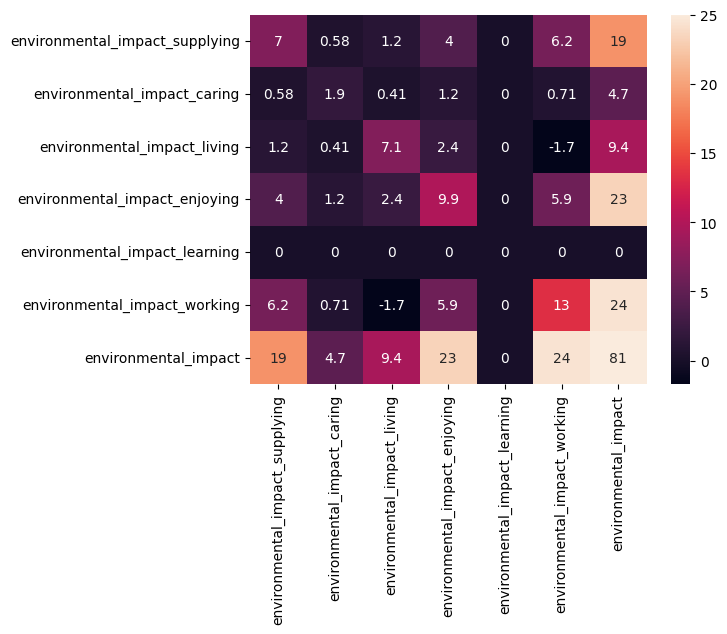

In [99]:
cov_df = hex_analysis.loc[hex_analysis.Nombre=='Nueva Alameda'].drop(columns=['Nombre','hex_id','res','geometry'])

covariance_variable = 'environmental_impact'
cov_cols = [c for c in cov_df.columns if covariance_variable in c]
cov_df = cov_df[cov_cols]

sns.heatmap(cov_df.cov(), vmax=25, annot=True)
plt.show()


In [98]:
cov_df.cov()['environmental_impact']

environmental_impact_supplying    18.969036
environmental_impact_caring        4.722738
environmental_impact_living        9.399569
environmental_impact_enjoying     23.264500
environmental_impact_learning      0.000000
environmental_impact_working      24.431950
environmental_impact              80.787793
Name: environmental_impact, dtype: float64

In [76]:
cov_df.mean()

environmental_impact_supplying     8.031887
environmental_impact_caring        5.492614
environmental_impact_living        5.789337
environmental_impact_enjoying      6.368052
environmental_impact_learning      0.000000
environmental_impact_working       5.753527
environmental_impact              31.435417
dtype: float64

<AxesSubplot: >

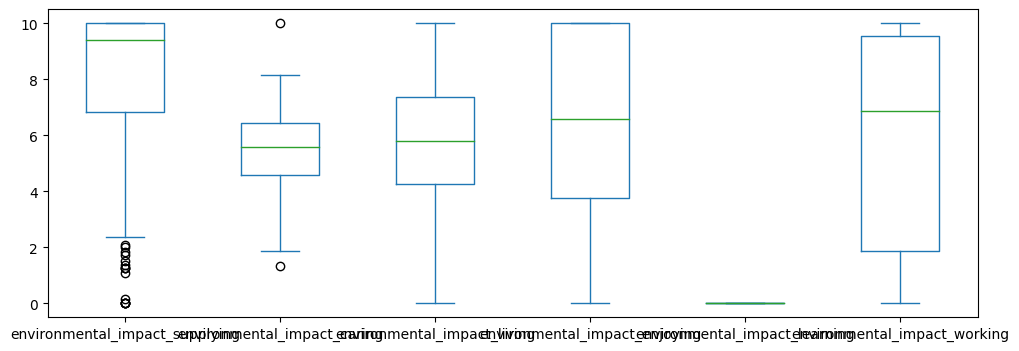

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
cov_df.drop(columns=[covariance_variable]).plot(kind='box', ax=ax)

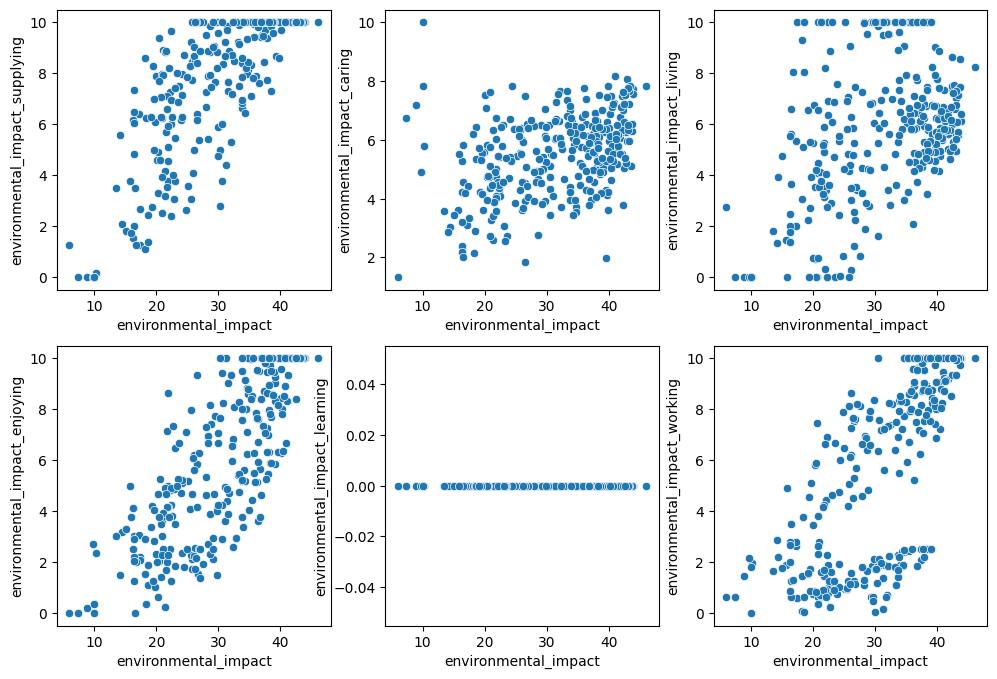

In [80]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
i = 0
col_list = list(cov_df.columns)
for r in range(2):
    for c in range(3):
        sns.scatterplot(cov_df, x=covariance_variable, y=col_list[i], ax=ax[r][c])
        i += 1